# Nepal Earthquake Damage Assessment Workflow

This notebook provides a complete workflow for post-disaster damage assessment using satellite imagery and GeoAI techniques.

## Event Information
- **Date**: November 3, 2023
- **Magnitude**: 6.4 ML (5.7 Mw)
- **Epicenter**: Ramidanda, Jajarkot District (28.84°N, 82.19°E)
- **Affected Districts**: Jajarkot, Rukum West, Salyan

## 1. Setup and Configuration

In [10]:
#issue just for me
import os
# choose a backend that exists; e.g. for non-interactive scripts:
os.environ['MPLBACKEND'] = 'agg'    
# or for interactive windows:
# os.environ['MPLBACKEND'] = 'tkagg'

import matplotlib.pyplot as plt


In [4]:
# 1) Force-install into the active kernel
%pip install matplotlib seaborn --quiet

# 2) Restart the kernel (after the install finishes), then in a fresh cell:

import sys
print("Python executable:", sys.executable)

# 3) Check that matplotlib truly imports and you can see where it lives:
import matplotlib
print("matplotlib version:", matplotlib.__version__)
print("matplotlib path:   ", matplotlib.__file__)

import matplotlib.pyplot as plt
print("pyplot imported ok:", plt)


Note: you may need to restart the kernel to use updated packages.
Python executable: c:\Users\wb636273\.conda\envs\capexdx\python.exe
matplotlib version: 3.9.4
matplotlib path:    c:\Users\wb636273\.conda\envs\capexdx\lib\site-packages\matplotlib\__init__.py
pyplot imported ok: <module 'matplotlib.pyplot' from 'c:\\Users\\wb636273\\.conda\\envs\\capexdx\\lib\\site-packages\\matplotlib\\pyplot.py'>


In [9]:
# Import required libraries
import os
import sys
import json
import warnings
from pathlib import Path
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML, Image
warnings.filterwarnings('ignore')

# Set up paths
SCRIPT_DIR = Path('./scripts')
sys.path.append(str(SCRIPT_DIR))

# Import custom modules
from scripts.data_acquisition import EarthquakeDataAcquisition
from scripts.preprocessing import ImagePreprocessor
from scripts.damage_analysis import DamageAnalyzer
from scripts.visualization import DamageVisualizer
from scripts.reporting import ReportGenerator

print("Setup complete!")

Setup complete!


## 2. Configuration

Create or load the configuration file with earthquake parameters and data paths.

In [10]:
# Configuration
config = {
    "data_dir": "./data",
    "earthquake": {
        "date": "2023-11-03",
        "epicenter": [82.19, 28.84],
        "magnitude": 6.4,
        "affected_districts": ["Jajarkot", "Rukum West", "Salyan"]
    },
    "date_ranges": {
        "pre_start": "2023-09-01",
        "pre_end": "2023-11-02",
        "post_start": "2023-11-04",
        "post_end": "2023-12-15"
    },
    "aoi_buffer_km": 50,
    "cloud_threshold": 20,
    "apis": {
        "planet_api_key": "",  # Add your API key if available
        "maxar_api_key": "",   # Add your API key if available
        "copernicus_user": "",
        "copernicus_pass": ""
    }
}

# Save configuration
with open('config.json', 'w') as f:
    json.dump(config, f, indent=4)

print("Configuration saved!")
print(f"Earthquake Date: {config['earthquake']['date']}")
print(f"Magnitude: {config['earthquake']['magnitude']}")
print(f"Epicenter: {config['earthquake']['epicenter']}")

Configuration saved!
Earthquake Date: 2023-11-03
Magnitude: 6.4
Epicenter: [82.19, 28.84]


## 3. Data Acquisition

Download and prepare satellite imagery from multiple sources.

In [18]:
import ee

# This will open a browser window so you can sign in to your Google Earth Engine account.
ee.Authenticate()  

# Once you’ve granted access, initialize the API.
ee.Initialize()  



Successfully saved authorization token.


In [19]:
# Initialize data acquisition
acquisition = EarthquakeDataAcquisition('config.json')

# Create area of interest
aoi = acquisition.create_aoi()
print(f"AOI created with {config['aoi_buffer_km']}km buffer around epicenter")

# Get district boundaries
districts = acquisition.get_district_boundaries()
print(f"\nAffected districts: {list(districts['district'])}")

2025-06-27 01:52:38,015 - scripts.data_acquisition - INFO - Google Earth Engine initialized successfully
2025-06-27 01:52:38,053 - scripts.data_acquisition - INFO - Created AOI with 50km buffer around epicenter


AOI created with 50km buffer around epicenter


2025-06-27 01:52:39,366 - pyogrio._io - INFO - Created 3 records
2025-06-27 01:52:39,369 - scripts.data_acquisition - INFO - Saved district boundaries to data\aoi\affected_districts.geojson



Affected districts: ['Jajarkot', 'Rukum West', 'Salyan']


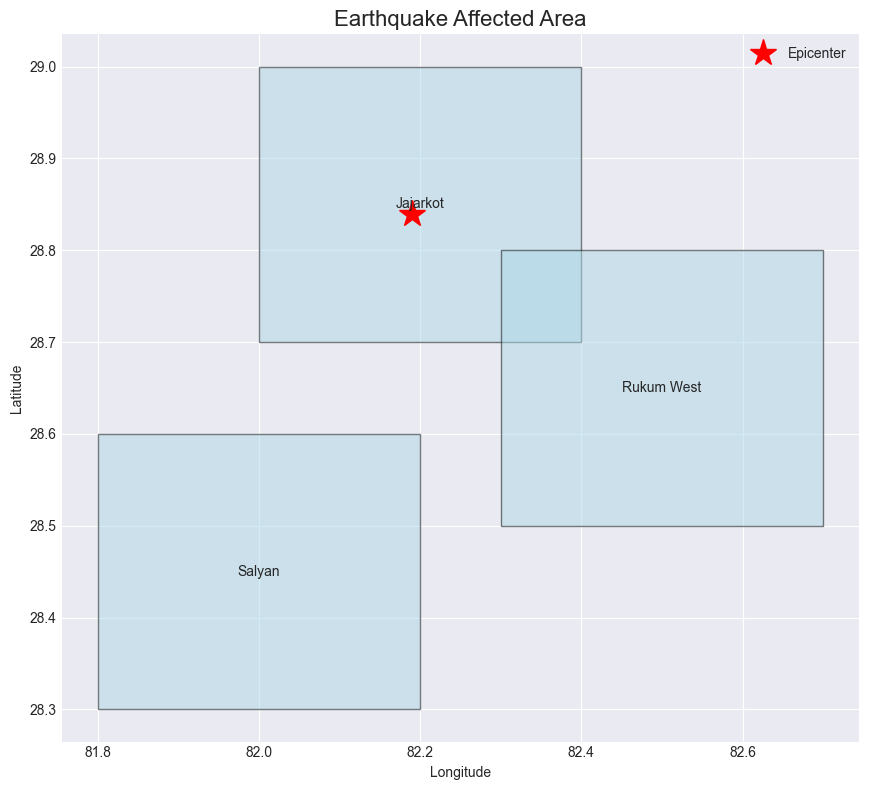

In [20]:
# Visualize AOI and affected districts
fig, ax = plt.subplots(figsize=(10, 8))

# Plot districts
districts.plot(ax=ax, color='lightblue', edgecolor='black', alpha=0.5)

# Plot epicenter
epicenter = config['earthquake']['epicenter']
ax.plot(epicenter[0], epicenter[1], 'r*', markersize=20, label='Epicenter')

# Add labels
for idx, row in districts.iterrows():
    centroid = row.geometry.centroid
    ax.text(centroid.x, centroid.y, row['district'], ha='center', va='center')

ax.set_title('Earthquake Affected Area', fontsize=16)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend()
plt.tight_layout()
plt.show()

In [22]:
# Run data acquisition pipeline
# Note: This will export data to Google Drive if using Google Earth Engine
# Make sure you have authenticated GEE first

print("Starting data acquisition...")
print("This process will:")
print("1. Search for cloud-free imagery")
print("2. Create composites for pre and post earthquake periods")
print("3. Export imagery to Google Drive")
print("4. Download ancillary data (OSM, elevation, population)")
print("\nNote: Large exports may take time to process on Google Earth Engine")

# Uncomment to run full acquisition
acquisition.run_acquisition_pipeline()

2025-06-27 01:53:13,272 - scripts.data_acquisition - INFO - Starting data acquisition pipeline for Nepal earthquake assessment
2025-06-27 01:53:13,277 - scripts.data_acquisition - INFO - Created AOI with 50km buffer around epicenter
2025-06-27 01:53:13,290 - pyogrio._io - INFO - Created 3 records
2025-06-27 01:53:13,294 - scripts.data_acquisition - INFO - Saved district boundaries to data\aoi\affected_districts.geojson
2025-06-27 01:53:13,296 - scripts.data_acquisition - INFO - Collecting pre-earthquake imagery...
2025-06-27 01:53:13,297 - scripts.data_acquisition - INFO - Fetching Sentinel-2 data from 2023-09-01 to 2023-11-02


Starting data acquisition...
This process will:
1. Search for cloud-free imagery
2. Create composites for pre and post earthquake periods
3. Export imagery to Google Drive
4. Download ancillary data (OSM, elevation, population)

Note: Large exports may take time to process on Google Earth Engine


2025-06-27 01:53:13,623 - scripts.data_acquisition - INFO - Found 20 Sentinel-2 images
2025-06-27 01:53:13,625 - scripts.data_acquisition - INFO - Fetching Landsat data from 2023-09-01 to 2023-11-02
2025-06-27 01:53:13,834 - scripts.data_acquisition - INFO - Found 11 Landsat images
2025-06-27 01:53:13,836 - scripts.data_acquisition - INFO - Fetching Sentinel-1 SAR data from 2023-09-01 to 2023-11-02
2025-06-27 01:53:14,181 - scripts.data_acquisition - INFO - Found 28 Sentinel-1 images
2025-06-27 01:53:14,184 - scripts.data_acquisition - INFO - Collecting post-earthquake imagery...
2025-06-27 01:53:14,185 - scripts.data_acquisition - INFO - Fetching Sentinel-2 data from 2023-11-04 to 2023-12-15
2025-06-27 01:53:14,641 - scripts.data_acquisition - INFO - Found 29 Sentinel-2 images
2025-06-27 01:53:14,644 - scripts.data_acquisition - INFO - Fetching Landsat data from 2023-11-04 to 2023-12-15
2025-06-27 01:53:15,003 - scripts.data_acquisition - INFO - Found 15 Landsat images
2025-06-27 01:5

## 4. Image Preprocessing

Prepare analysis-ready data through preprocessing steps.

In [26]:
Path(config['data_dir'])

WindowsPath('data')

In [25]:
# Initialize preprocessor
preprocessor = ImagePreprocessor('config.json')

# Define paths to downloaded images
data_dir = Path(config['data_dir'])
downloads_dir = data_dir / 'downloads'

# Check available images
if downloads_dir.exists():
    available_images = list(downloads_dir.glob('*.tif'))
    print(f"Found {len(available_images)} images:")
    for img in available_images:
        print(f"  - {img.name}")
else:
    print("No downloaded images found. Please run data acquisition first.")

No downloaded images found. Please run data acquisition first.


In [ ]:
# Create analysis-ready data (ARD)
# This process includes:
# - Co-registration
# - Radiometric correction
# - Cloud masking
# - Clipping to AOI

pre_image = downloads_dir / 'sentinel2_pre_earthquake.tif'
post_image = downloads_dir / 'sentinel2_post_earthquake.tif'
aoi_file = data_dir / 'aoi' / 'affected_districts.geojson'

if pre_image.exists() and post_image.exists():
    print("Creating analysis-ready data...")
    ard = preprocessor.create_analysis_ready_data(
        str(pre_image),
        str(post_image),
        str(aoi_file) if aoi_file.exists() else None
    )
    
    print("\nARD created:")
    print(f"Pre-earthquake: {ard['pre']}")
    print(f"Post-earthquake: {ard['post']}")
    print(f"\nCloud coverage:")
    print(f"Pre: {ard['metadata']['pre_cloud_percentage']:.2f}%")
    print(f"Post: {ard['metadata']['post_cloud_percentage']:.2f}%")
else:
    print("Required images not found. Using sample data...")

## 5. Damage Analysis

Perform comprehensive damage assessment using multiple techniques.

In [ ]:
# Initialize damage analyzer
analyzer = DamageAnalyzer('config.json')

# Define input paths
processed_dir = data_dir / 'processed' / 'ard'
pre_ard = processed_dir / 'pre_ard.tif'
post_ard = processed_dir / 'post_ard.tif'

# Check if ARD exists
if pre_ard.exists() and post_ard.exists():
    print("Analysis-ready data found!")
    print("Running damage analysis...")
    
    # Calculate spectral indices
    pre_indices, metadata = analyzer.calculate_spectral_indices(str(pre_ard))
    post_indices, _ = analyzer.calculate_spectral_indices(str(post_ard))
    
    # Calculate changes
    changes = analyzer.change_detection(pre_indices, post_indices)
    
    print("\nCalculated indices:")
    for idx in pre_indices.keys():
        print(f"  - {idx}")
    
    print("\nChange indices:")
    for idx in changes.keys():
        print(f"  - {idx}")
else:
    print("ARD not found. Please run preprocessing first.")

In [ ]:
# Visualize spectral changes
if 'changes' in locals():
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.ravel()
    
    # Plot key change indices
    indices_to_plot = ['dndvi', 'dnbr', 'dndbi', 'dbsi']
    
    for i, idx in enumerate(indices_to_plot):
        if idx in changes:
            im = axes[i].imshow(changes[idx], cmap='RdYlGn_r', vmin=-0.5, vmax=0.5)
            axes[i].set_title(f'{idx.upper()} Change', fontsize=12)
            axes[i].axis('off')
            plt.colorbar(im, ax=axes[i], fraction=0.046)
    
    plt.suptitle('Spectral Index Changes (Post - Pre Earthquake)', fontsize=16)
    plt.tight_layout()
    plt.show()

In [ ]:
# Run comprehensive damage assessment
if pre_ard.exists() and post_ard.exists():
    print("Running comprehensive damage assessment...")
    print("This includes:")
    print("- Spectral change analysis")
    print("- Texture analysis")
    print("- Machine learning classification")
    print("- Building damage assessment")
    print("- Landslide detection")
    
    # Additional input files
    pre_sar = processed_dir / 'sentinel1_pre_earthquake.tif'
    post_sar = processed_dir / 'sentinel1_post_earthquake.tif'
    buildings = data_dir / 'ancillary' / 'osm_buildings.geojson'
    slope = data_dir / 'ancillary' / 'slope.tif'
    
    # Run assessment
    results = analyzer.comprehensive_damage_assessment(
        str(pre_ard),
        str(post_ard),
        str(pre_sar) if pre_sar.exists() else None,
        str(post_sar) if post_sar.exists() else None,
        str(buildings) if buildings.exists() else None,
        str(slope) if slope.exists() else None
    )
    
    print("\nAssessment complete!")
    print(f"Results saved to: {analyzer.results_dir}")
    
    # Display statistics
    if 'statistics' in results:
        print("\nDamage Statistics:")
        stats = results['statistics']
        if 'damage_distribution' in stats:
            for level, data in stats['damage_distribution'].items():
                print(f"  {level}: {data['area_km2']:.2f} km² ({data['percentage']:.1f}%)")

## 6. Visualization

Create various visualizations of the damage assessment results.

In [ ]:
# Initialize visualizer
visualizer = DamageVisualizer('config.json')

# Create before/after comparison
if pre_ard.exists() and post_ard.exists():
    print("Creating before/after comparison...")
    fig = visualizer.create_before_after_comparison(
        str(pre_ard),
        str(post_ard)
    )
    plt.show()

In [ ]:
# Visualize damage map
damage_map_path = analyzer.results_dir / 'damage_classification.tif'

if damage_map_path.exists():
    print("Visualizing damage map...")
    fig = visualizer.visualize_damage_map(str(damage_map_path))
    plt.show()

In [ ]:
# Create interactive map
building_damage_path = analyzer.results_dir / 'building_damage_assessment.geojson'

if building_damage_path.exists():
    print("Creating interactive map...")
    interactive_map = visualizer.create_interactive_map(str(building_damage_path))
    display(interactive_map)
elif damage_map_path.exists():
    print("Creating interactive map from raster...")
    interactive_map = visualizer.create_interactive_map(str(damage_map_path))
    display(interactive_map)

In [ ]:
# Plot damage statistics
stats_path = analyzer.results_dir / 'damage_assessment_report.json'

if stats_path.exists():
    print("Creating statistical plots...")
    fig = visualizer.plot_damage_statistics(str(stats_path))
    plt.show()

## 7. Report Generation

Generate comprehensive reports in multiple formats.

In [ ]:
# Initialize report generator
reporter = ReportGenerator('config.json')

print("Generating reports...")
print("This will create:")
print("- PDF report")
print("- Excel workbook with detailed data")
print("- GIS outputs (Shapefile, GeoPackage, KML)")
print("- Web-based report")

# Generate all reports
reports = reporter.generate_all_reports()

print("\nGenerated reports:")
for report_type, path in reports.items():
    if isinstance(path, dict):
        print(f"\n{report_type}:")
        for sub_type, sub_path in path.items():
            print(f"  - {sub_type}: {sub_path}")
    else:
        print(f"{report_type}: {path}")

## 8. GeoAI Integration

Demonstrate how to integrate with GeoAI platforms and tools.

In [ ]:
# GeoAI Integration Examples

print("GeoAI Integration Options:")
print("\n1. ESRI ArcGIS GeoAI:")
print("   - Use pre-trained models from ArcGIS Living Atlas")
print("   - Export results as feature services")
print("   - Integrate with ArcGIS Pro for advanced analysis")

print("\n2. Google Earth Engine:")
print("   - Already integrated for data acquisition")
print("   - Can export results back to GEE for further analysis")

print("\n3. Microsoft Planetary Computer:")
print("   - Access additional satellite data")
print("   - Use Azure ML for scalable processing")

print("\n4. NASA-IBM Prithvi Model:")
print("   - Foundation model for geospatial analysis")
print("   - Can be fine-tuned for earthquake damage")

# Example: Prepare data for ESRI GeoAI
gis_outputs = reports.get('gis', {})
if 'shapefile' in gis_outputs:
    print(f"\nShapefile ready for ArcGIS: {gis_outputs['shapefile']}")
    print("To use in ArcGIS Pro:")
    print("1. Add shapefile to map")
    print("2. Apply damage classification symbology")
    print("3. Use Spatial Analyst for hotspot analysis")
    print("4. Create StoryMap for public communication")

In [ ]:
# Example: Prepare for deep learning with PyTorch
print("Preparing data for deep learning...")

if damage_map_path.exists():
    import rasterio
    from torch.utils.data import Dataset, DataLoader
    import torch
    
    class DamageDataset(Dataset):
        def __init__(self, pre_path, post_path, damage_path, patch_size=256):
            self.pre_path = pre_path
            self.post_path = post_path
            self.damage_path = damage_path
            self.patch_size = patch_size
            
            # Load metadata
            with rasterio.open(damage_path) as src:
                self.height = src.height
                self.width = src.width
        
        def __len__(self):
            # Number of patches
            return (self.height // self.patch_size) * (self.width // self.patch_size)
        
        def __getitem__(self, idx):
            # Get patch coordinates
            patches_per_row = self.width // self.patch_size
            row = idx // patches_per_row
            col = idx % patches_per_row
            
            # Define window
            window = rasterio.windows.Window(
                col * self.patch_size,
                row * self.patch_size,
                self.patch_size,
                self.patch_size
            )
            
            # Read patches
            with rasterio.open(self.pre_path) as src:
                pre_patch = src.read(window=window)
            
            with rasterio.open(self.post_path) as src:
                post_patch = src.read(window=window)
            
            with rasterio.open(self.damage_path) as src:
                damage_patch = src.read(1, window=window)
            
            # Stack pre and post images
            combined = np.concatenate([pre_patch, post_patch], axis=0)
            
            return {
                'image': torch.FloatTensor(combined),
                'label': torch.LongTensor(damage_patch)
            }
    
    print("Dataset class created for PyTorch training")
    print("This can be used to train custom CNN models for damage detection")

## 9. Summary and Next Steps

In [ ]:
print("=" * 60)
print("DAMAGE ASSESSMENT WORKFLOW COMPLETE")
print("=" * 60)

print("\nSummary of outputs:")
print(f"\n1. Data Directory: {data_dir}")
print(f"   - Raw imagery: {data_dir / 'downloads'}")
print(f"   - Processed data: {data_dir / 'processed'}")
print(f"   - Results: {data_dir / 'results'}")

print("\n2. Key Results:")
if stats_path.exists():
    with open(stats_path, 'r') as f:
        stats = json.load(f)
    
    if 'total_area_km2' in stats:
        print(f"   - Total assessed area: {stats['total_area_km2']:.2f} km²")
    
    if 'damage_distribution' in stats:
        severe = stats['damage_distribution'].get('Severe', {}).get('area_km2', 0)
        high = stats['damage_distribution'].get('High', {}).get('area_km2', 0)
        print(f"   - Severe damage: {severe:.2f} km²")
        print(f"   - High damage: {high:.2f} km²")

print("\n3. Reports Generated:")
if 'reports' in locals():
    if 'pdf' in reports:
        print(f"   - PDF Report: {reports['pdf']}")
    if 'excel' in reports:
        print(f"   - Excel Report: {reports['excel']}")
    if 'web' in reports:
        print(f"   - Web Report: {reports['web']}")

print("\n4. Next Steps:")
print("   - Share results with disaster response teams")
print("   - Validate with ground truth data")
print("   - Monitor recovery progress with follow-up imagery")
print("   - Integrate with emergency management systems")
print("   - Use results for reconstruction planning")

print("\n5. GeoAI Enhancement Options:")
print("   - Fine-tune deep learning models with local data")
print("   - Integrate with cloud-based GeoAI platforms")
print("   - Develop mobile apps for field validation")
print("   - Create real-time monitoring systems")

## Additional Resources

### Data Sources
- [Google Earth Engine](https://earthengine.google.com/)
- [Copernicus Open Access Hub](https://scihub.copernicus.eu/)
- [USGS EarthExplorer](https://earthexplorer.usgs.gov/)
- [NASA Earthdata](https://earthdata.nasa.gov/)

### GeoAI Platforms
- [ESRI ArcGIS GeoAI](https://www.esri.com/en-us/capabilities/geoai/overview)
- [Microsoft Planetary Computer](https://planetarycomputer.microsoft.com/)
- [Google Earth Engine](https://earthengine.google.com/)
- [NASA-IBM Prithvi](https://huggingface.co/ibm-nasa-geospatial)
- [Picterra](https://picterra.ch/)
- [Orbital Insight](https://orbitalinsight.com/)

### Documentation
- [Sentinel-2 User Guide](https://sentinel.esa.int/web/sentinel/user-guides/sentinel-2-msi)
- [USGS Landsat Documentation](https://www.usgs.gov/landsat-missions/landsat-collection-2)
- [UN-SPIDER Knowledge Portal](https://www.un-spider.org/)
- [Copernicus Emergency Management Service](https://emergency.copernicus.eu/)

### Research Papers
- Geospatial AI for Disaster Response
- Deep Learning for Building Damage Assessment
- SAR Coherence Analysis for Earthquake Damage
- Multi-temporal Change Detection Methods